# Постановка задачи

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# Технологический процесс

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.
1. Флотация \
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка\
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.
Описание данных\
Технологический процесс\
Rougher feed — исходное сырье\
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant\
Xanthate — ксантогенат (промотер, или активатор флотации);\
Sulphate — сульфат (на данном производстве сульфид натрия);\
Depressant — депрессант (силикат натрия).\
Rougher process (англ. «грубый процесс») — флотация\
Rougher tails — отвальные хвосты\
Float banks — флотационная установка\
Cleaner process — очистка\
Rougher Au — черновой концентрат золота\
Final Au — финальный концентрат золота\
Параметры этапов\
air amount — объём воздуха\
fluid levels — уровень жидкости\
feed size — размер гранул сырья\
feed rate — скорость подачи\
Наименование признаков:\
[этап].[тип_параметра].[название_параметра]\
Пример: rougher.input.feed_ag\
Возможные значения для блока [этап]:\
rougher — флотация\
primary_cleaner — первичная очистка\
secondary_cleaner — вторичная очистка\
final — финальные характеристики\
Возможные значения для блока [тип_параметра]:\
input — параметры сырья\
output — параметры продукта\
state — параметры, характеризующие текущее состояние этапа\
calculation — расчётные характеристики\

# Расчёт эффективности

Нужно смоделировать процесс восстановления золота из золотосодержащей руды.\
Эффективность обогащения рассчитывается по формуле:\
RECOVERY = C*(F-T)/F*(C-T) * 100%\
где:
C — доля золота в концентрате после флотации/очистки;\
F — доля золота в сырье/концентрате до флотации/очистки;\
T — доля золота в отвальных хвостах после флотации/очистки.\
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

# Метрика качества

Для решения задачи используем метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).\
Нужно спрогнозировать сразу две величины:\
эффективность обогащения чернового концентрата rougher.output.recovery;\
эффективность обогащения финального концентрата final.output.recovery.\
Итоговая метрика складывается из двух величин:\
Итоговое sMAPE = 25% sMAPE(rougher) + 75% sMAPE(final)

# Данные

Данные находятся в трёх файлах:
gold_recovery_train_new.csv — обучающая выборка;
gold_recovery_test_new.csv — тестовая выборка;
gold_recovery_full_new.csv — исходные данные.
Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
import warnings

warnings.filterwarnings("ignore")

## Анализ данных

### Первичный анализ

In [2]:
train = pd.read_csv('/datasets/gold_recovery_full_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
print(train.shape, test.shape, full.shape)

(19439, 87) (5290, 53) (19439, 87)


In [4]:
display(train.info())
display(test.info())
display(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

### Проверка расчета эффективности обогащения
Вычислим её на обучающей выборке для признака rougher.output.recovery

In [5]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']
train['rougher.output.recovery_calc'] = (C*(F-T))/(F*(C-T))*100
mae = mean_absolute_error(train['rougher.output.recovery'], train['rougher.output.recovery_calc'])
mae

9.874045668302637e-15

Эффективность обогащения рассчитана правильно: среднее абсолютное отклонение равно нулю.

### Анализ признаков, недоступных в тестовой выборке

In [6]:
absent_columns = []
train_columns = train.columns
test_columns = test.columns
for column in train_columns:
    if column not in test_columns:
        absent_columns.append(column)
absent_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке нет: 
1) выходов ценных металлов в концентрате и хвостах для всех этапов обогащения; эти данные для этапов final и rougher используются для расчета целевых признаков  'final.output.recovery' и 'rougher.output.recovery', поэтому для входа в модель не нужны (иначе будет утечка целевого признака); выходы металлов на этапах primary_cleaner и secondary_cleaner зависят от выхода на этапе rougher, а также от прочих признаков, поэтому также будут давать модели информацию о целевом признаке и **не должны подаваться на вход в модель**  
2) целевых признаков: 'final.output.recovery' и 'rougher.output.recovery'; их **нужно добавить из полной выборки**  
3) расчетных показателей (видимо, предполагается, что они посчитаны на уже имеющихся в выборке данных, а потому имеют высокую корреляцию с другими признаками, поэтому **не должны подаваться на вход в модель**  
**Вывод: в признаках не должно быть показателей с словами output и calculation. Используем это при подготовке признаков для обучения в п. 1.4**

### Предобработка данных

Добавим 'final.output.recovery' и  'rougher.output.recovery' в тестовую выборку. Для этого воспользуемся датой как индексом. Приведем дату к офрмату даты из текста.

In [7]:
test['date']= pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')
full['date']= pd.to_datetime(full['date'], format='%Y-%m-%d %H:%M:%S')
test.info()
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

Добавим 'final.output.recovery' и  'rougher.output.recovery' в тестовую выборку.

In [8]:
recovery_to_add = full[['date','final.output.recovery','rougher.output.recovery']]
test = test.merge(recovery_to_add, on='date')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

#### Признаки для обучения
Согласно выводу в п.1.3 в признаках не должно быть показателей с словами output и calculation.

In [9]:
features_list = []
for column in train.columns:
    if 'output' not in column and 'calculation' not in column:
        features_list.append(column)
        
features_train = train[features_list]
target_train = train[['final.output.recovery','rougher.output.recovery']]

Удалим нулевые целевые признаки

In [10]:
target_train = target_train[target_train['final.output.recovery'] !=0]
target_train = target_train[target_train['rougher.output.recovery'] !=0]
target_train.shape

(18949, 2)

Удалим соответствующие нулевым целевым признакам, признаки для обучения

In [11]:
features_train = features_train.iloc[target_train.index]
features_train.shape

(18949, 53)

##### Анализ взаимосвязей признаков

Сделаем функцию, которая принимает матрицу корреляции и значение порога коэффициента корреляции, и возвращающую признаки с корреляцией выше порога.

In [12]:
def high_corr (corr_matrix, corr_rate):
    high_corr_list = []
    for column in corr_matrix.columns:
        high_corr_list.append(corr_matrix.loc[(corr_matrix.loc[:,column]> abs(corr_rate)) & (corr_matrix.loc[:,column]< abs(1))][column])
    display (high_corr_list)

high_corr(features_train.corr(), 0.85)

[Series([], Name: primary_cleaner.input.sulfate, dtype: float64),
 Series([], Name: primary_cleaner.input.depressant, dtype: float64),
 Series([], Name: primary_cleaner.input.feed_size, dtype: float64),
 Series([], Name: primary_cleaner.input.xanthate, dtype: float64),
 primary_cleaner.state.floatbank8_b_air    0.953457
 primary_cleaner.state.floatbank8_c_air    0.915580
 Name: primary_cleaner.state.floatbank8_a_air, dtype: float64,
 primary_cleaner.state.floatbank8_b_level    0.866530
 primary_cleaner.state.floatbank8_c_level    0.942141
 Name: primary_cleaner.state.floatbank8_a_level, dtype: float64,
 primary_cleaner.state.floatbank8_a_air    0.953457
 primary_cleaner.state.floatbank8_c_air    0.925092
 Name: primary_cleaner.state.floatbank8_b_air, dtype: float64,
 primary_cleaner.state.floatbank8_a_level    0.86653
 Name: primary_cleaner.state.floatbank8_b_level, dtype: float64,
 primary_cleaner.state.floatbank8_a_air    0.915580
 primary_cleaner.state.floatbank8_b_air    0.925092
 

Исключим признаки с корреляцией больше 0,85 из features_train

In [13]:
to_drop = ['primary_cleaner.state.floatbank8_b_air', 'primary_cleaner.state.floatbank8_c_air',
           'primary_cleaner.state.floatbank8_b_level','primary_cleaner.state.floatbank8_c_level',
          'rougher.input.feed_ag',
          'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate',
           'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_f_air',
           'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_level',
           'secondary_cleaner.state.floatbank2_b_air', 'secondary_cleaner.state.floatbank4_b_air', 'secondary_cleaner.state.floatbank5_b_air',
           'secondary_cleaner.state.floatbank2_b_level'
          ]
display(len(to_drop))
features_train = features_train.drop(to_drop, axis=1)

18

Проверим, что не осталось признаков с корреляцией больше 0,85

In [14]:
high_corr(features_train.corr(), 0.85)

[Series([], Name: primary_cleaner.input.sulfate, dtype: float64),
 Series([], Name: primary_cleaner.input.depressant, dtype: float64),
 Series([], Name: primary_cleaner.input.feed_size, dtype: float64),
 Series([], Name: primary_cleaner.input.xanthate, dtype: float64),
 Series([], Name: primary_cleaner.state.floatbank8_a_air, dtype: float64),
 Series([], Name: primary_cleaner.state.floatbank8_a_level, dtype: float64),
 Series([], Name: primary_cleaner.state.floatbank8_d_air, dtype: float64),
 Series([], Name: primary_cleaner.state.floatbank8_d_level, dtype: float64),
 Series([], Name: rougher.input.feed_pb, dtype: float64),
 Series([], Name: rougher.input.feed_rate, dtype: float64),
 Series([], Name: rougher.input.feed_size, dtype: float64),
 Series([], Name: rougher.input.feed_sol, dtype: float64),
 Series([], Name: rougher.input.feed_au, dtype: float64),
 Series([], Name: rougher.input.floatbank10_sulfate, dtype: float64),
 Series([], Name: rougher.input.floatbank10_xanthate, dtype: 

Список пустых списков: признаков с корреляцией больше 0,85 в обучающей выборке нет.

##### Заполнение пропусков

Посмотрим на пропуски в features_train.

In [15]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18949 entries, 0 to 19438
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        18949 non-null  object 
 1   primary_cleaner.input.sulfate               18929 non-null  float64
 2   primary_cleaner.input.depressant            18921 non-null  float64
 3   primary_cleaner.input.feed_size             18949 non-null  float64
 4   primary_cleaner.input.xanthate              18852 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      18945 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    18948 non-null  float64
 7   primary_cleaner.state.floatbank8_d_air      18946 non-null  float64
 8   primary_cleaner.state.floatbank8_d_level    18948 non-null  float64
 9   rougher.input.feed_pb                       18849 non-null  float64
 10  rougher.in

Так как соседние по времени параметры часто похожи, заполненим пропуски ранее наблюдавшимися значениями.

In [16]:
features_train.ffill(axis = 0,inplace=True)
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18949 entries, 0 to 19438
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        18949 non-null  object 
 1   primary_cleaner.input.sulfate               18949 non-null  float64
 2   primary_cleaner.input.depressant            18949 non-null  float64
 3   primary_cleaner.input.feed_size             18949 non-null  float64
 4   primary_cleaner.input.xanthate              18949 non-null  float64
 5   primary_cleaner.state.floatbank8_a_air      18949 non-null  float64
 6   primary_cleaner.state.floatbank8_a_level    18949 non-null  float64
 7   primary_cleaner.state.floatbank8_d_air      18949 non-null  float64
 8   primary_cleaner.state.floatbank8_d_level    18949 non-null  float64
 9   rougher.input.feed_pb                       18949 non-null  float64
 10  rougher.in

#### Признаки для тестирования

In [17]:
features_test = test.drop(columns=['final.output.recovery', 'rougher.output.recovery'], axis=1)
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

Заполненим пропуски ранее наблюдавшимися значениями.

In [18]:
features_test.ffill(axis = 0,inplace=True)
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5290 non-null   float64       
 2   primary_cleaner.input.depressant            5290 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5290 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

Проверим, что набор признаков для обучения совпадает с набором признаков для тестирования

In [19]:
# найдем столбцы в features_train, которых нет в features_test
absent_columns = []

for column in features_train.columns:
    if column not in features_test.columns:
        absent_columns.append(column)
absent_columns

[]

In [20]:
# найдем столбцы в features_test, которых нет в features_train
absent_columns = []

for column in features_test.columns:
    if column not in features_train.columns:
        absent_columns.append(column)
absent_columns

['primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'rougher.input.feed_ag',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_d_air',
 'rougher.state.floatbank10_d_level',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'rougher.state.floatbank10_f_level',
 'secondary_cleaner.state.floatbank2_b_air',
 'secondary_cleaner.state.floatbank2_b_level',
 'secondary_cleaner.state.floatbank4_b_air',
 'secondary_cleaner.state.floatbank5_b_air']

Удалим "лишние" признаки из тестового набора признаков

In [21]:
features_test = features_test.drop(columns=absent_columns, axis=1)
features_test.shape

(5290, 35)

Вывод: В тестовых признаках есть признаки, для которых зафиксирована высокая корреляция в обучающем наборе.
Эти признаки не будут использованы моделью, оставим их в тестовой выборке.

### Анализ данных

#### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [22]:
print('ag:','pb:', 'au:', 'sol:')

input_ag = full['rougher.input.feed_ag'].mean()
input_pb = full['rougher.input.feed_pb'].mean()
input_au = full['rougher.input.feed_au'].mean()
input_sol = full['rougher.input.feed_sol'].mean()
print( input_ag,  input_pb, input_au, input_sol)

rougher_concentrate_ag = full['rougher.output.concentrate_ag'].mean()
rougher_concentrate_pb = full['rougher.output.concentrate_pb'].mean()
rougher_concentrate_au = full['rougher.output.concentrate_au'].mean()
rougher_concentrate_sol = full['rougher.output.concentrate_sol'].mean()
print( rougher_concentrate_ag,  rougher_concentrate_pb, rougher_concentrate_au, rougher_concentrate_sol)

primary_cleaner_concentrate_ag = full['primary_cleaner.output.concentrate_ag'].mean()
primary_cleaner_concentrate_pb = full['primary_cleaner.output.concentrate_pb'].mean()
primary_cleaner_concentrate_au = full['primary_cleaner.output.concentrate_au'].mean()
print( primary_cleaner_concentrate_ag, primary_cleaner_concentrate_pb, primary_cleaner_concentrate_au)

final_concentrate_ag = full['final.output.concentrate_ag'].mean()
final_concentrate_pb = full['final.output.concentrate_pb'].mean()
final_concentrate_au = full['final.output.concentrate_au'].mean()
print( final_concentrate_ag, final_concentrate_pb, final_concentrate_au)

ag: pb: au: sol:
8.794927425814688 3.598084975395463 8.266097326589103 36.695114365904274
11.994759359873429 7.606272313195003 19.772000139486316 28.805570735676206
8.44240807771906 9.829529774200518 32.1194004078765
5.168470373676801 9.978894911181722 44.0765129419528


С каждой стадией очистки растет доля золота, незначительно растет доля свинца и снижается доля серебра

In [23]:
rougher_tail_ag = full['rougher.output.tail_ag'].mean()
rougher_tail_pb = full['rougher.output.tail_pb'].mean()
rougher_tail_au = full['rougher.output.tail_au'].mean()
print(rougher_tail_ag, rougher_tail_pb, rougher_tail_au)

primary_cleaner_tail_ag = full['primary_cleaner.output.tail_ag'].mean()
primary_cleaner_tail_pb = full['primary_cleaner.output.tail_pb'].mean()
primary_cleaner_tail_au = full['primary_cleaner.output.tail_au'].mean()
print(primary_cleaner_tail_ag, primary_cleaner_tail_pb, primary_cleaner_tail_au)

secondary_cleaner_tail_ag = full['secondary_cleaner.output.tail_ag'].mean()
secondary_cleaner_tail_pb = full['secondary_cleaner.output.tail_pb'].mean()
secondary_cleaner_tail_au = full['secondary_cleaner.output.tail_au'].mean()
print(secondary_cleaner_tail_ag, secondary_cleaner_tail_pb, secondary_cleaner_tail_au)

final_tail_ag = full['final.output.tail_ag'].mean()
final_tail_pb = full['final.output.tail_pb'].mean()
final_tail_au = full['final.output.tail_au'].mean()
print(final_tail_ag, final_tail_pb, final_tail_au)

5.588982001922016 0.6457823595518426 1.816391267460359
16.145825860528003 3.4356562759055933 3.9141788557795305
14.586832967264986 5.7777032878735115 4.339624592493953
9.688588602547483 2.705795398146629 3.0424669750207456


Доля металлов в хвостах ожидаемо существенно ниже, чем в концентрате особенно для целевого продукта. В хвостах доля металлов растет до этапа secondary_cleaner, снижаясь ни последнем этапе. Только концентрация серебра изменяется по-другому на 2 и 3 этапах: концентрация в secondary_cleaner ниже, чем в primary_cleaner.

#### Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

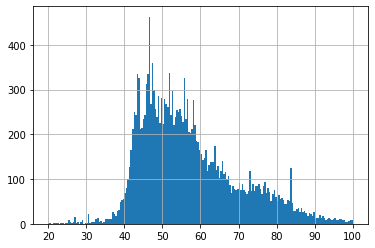

count    19294.000000
mean        58.970310
std         21.634478
min          0.046369
25%         47.435103
50%         54.610197
75%         65.023044
max        484.967466
Name: rougher.input.feed_size, dtype: float64

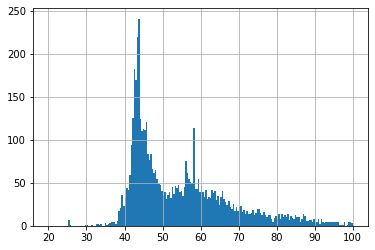

count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher.input.feed_size, dtype: float64

In [24]:
train['rougher.input.feed_size'].hist(bins=200, range=(20, 100))
plt.show()
display(train['rougher.input.feed_size'].describe())

test['rougher.input.feed_size'].hist(bins=200, range=(20, 100))
plt.show()
display(test['rougher.input.feed_size'].describe())

Размер гранул в обучающей выборке в среднем больше, чем в тестовой (59 против 56). Дисперсия тоже выше. Распределение тестовой выборки имеет 2 пика, обучающая выборка более равномерна.

#### Исключение выбросов данных
Уберем крайние значения в признаке 'rougher.input.feed_size' из признаков для обучения и соответствующие им целевые признаки

In [25]:
features_train = features_train[features_train['rougher.input.feed_size'] > 40]
features_train = features_train[features_train['rougher.input.feed_size'] < 80]
display(features_train['rougher.input.feed_size'].describe())
print(features_train.shape)

count    16836.000000
mean        55.456000
std          9.892774
min         40.000617
25%         47.425783
50%         53.836574
75%         61.580698
max         79.996255
Name: rougher.input.feed_size, dtype: float64

(16836, 35)


In [26]:
target_train= train[['rougher.output.recovery','final.output.recovery']]
target_train= target_train.iloc[features_train.index]
target_train.shape

(16836, 2)

####  Суммарная концентрация всех веществ на разных стадиях

In [27]:
print('rougher:','primary_cleaner:', 'final_concentrate:')
rougher_concentrate_me = rougher_concentrate_ag + rougher_concentrate_pb + rougher_concentrate_au
primary_cleaner_concentrate_me = primary_cleaner_concentrate_ag + primary_cleaner_concentrate_pb + primary_cleaner_concentrate_au
final_concentrate_me = final_concentrate_ag + final_concentrate_pb + final_concentrate_au
print(rougher_concentrate_me,  primary_cleaner_concentrate_me, final_concentrate_me)

rougher: primary_cleaner: final_concentrate:
39.37303181255475 50.39133825979607 59.22387822681132


С каждым этапом очистки доля металлов растет.

#### Удаление нулевых значений с содержанием вещества

In [28]:
full['input'] =  full['rougher.input.feed_ag']+full['rougher.input.feed_pb'] +full['rougher.input.feed_au']+ full['rougher.input.feed_sol']
full['rougher_output'] =  full['rougher.output.concentrate_ag']+full['rougher.output.concentrate_pb'] +full['rougher.output.concentrate_au']+ full['rougher.output.concentrate_sol']
full['primary_output'] =  full['primary_cleaner.output.concentrate_ag']+full['primary_cleaner.output.concentrate_pb'] +full['primary_cleaner.output.concentrate_au']+ full['primary_cleaner.output.concentrate_sol']
full['output'] =  full['final.output.concentrate_ag']+full['final.output.concentrate_pb'] +full['final.output.concentrate_au']+ full['final.output.concentrate_sol']
print('нулевые input',full[full['input'] ==0].shape)
print('нулевые rougher_output', full[full['rougher_output'] ==0].shape)
print('нулевые primary_output',full[full['primary_output'] ==0].shape)
print('нулевые output',full[full['output'] ==0].shape)
print('full',full.shape)
full = full.drop(full[full['input'] == 0].index)
full = full.drop(full[full['rougher_output'] == 0].index)
full = full.drop(full[full['primary_output'] == 0].index)
full = full.drop(full[full['output'] == 0].index)
print('full',full.shape)

нулевые input (0, 91)
нулевые rougher_output (394, 91)
нулевые primary_output (108, 91)
нулевые output (98, 91)
full (19439, 91)
full (18848, 91)


## Модель

### признаки для обучения и тестирования. 
Cначала переведем столбец с датой в индекс, чтобы остались только признаки для обучения / тестирования

In [29]:
features_train.set_index(features_train['date'], drop=True, inplace=True)
features_test.set_index(features_test['date'], drop=True, inplace=True)
features_train = features_train.drop(columns=['date'])
features_test = features_test.drop(columns=['date'])

In [30]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
scaler.fit(features_test)
features_test_scaled = scaler.transform(features_test)

# Признаки в обучающей выборке
features_train = pd.DataFrame(features_train_scaled, index=features_train.index, columns=features_train.columns)
# Признаки в тестовой выборке
features_test = pd.DataFrame(features_test_scaled, index=features_test.index, columns=features_test.columns)
print(features_train.shape,features_test.shape)

(16836, 34) (5290, 34)


### Целевые признаки

In [31]:
# Целевые признаки в обучающей выборке
target_rougher_train = target_train['rougher.output.recovery']
target_final_train = target_train['final.output.recovery']
# Целевые признаки в тестовой выборке
target_rougher_test = test['rougher.output.recovery']
target_final_test = test['final.output.recovery']
print(target_rougher_train.shape,target_final_train.shape)
print(target_rougher_test.shape,target_final_test.shape)

(16836,) (16836,)
(5290,) (5290,)


### Функция для вычисления sMAPE

In [32]:
target = []
forecast = []
def smape(target, forecast):
    return abs(1/len(target) * np.sum(2 * np.abs(forecast-target) / (np.abs(target) + np.abs(forecast))*100))
smape_scorer = make_scorer(smape)

### Модель регрессии

#### sMAPE для rougher_recovery

In [33]:
%%time
warnings.filterwarnings("ignore")

model_LR_rougher = LinearRegression()
model_LR_rougher.fit(features_train, target_rougher_train)
predictions = model_LR_rougher.predict(features_train)
smape_rougher =abs(cross_val_score(model_LR_rougher, features_train, target_rougher_train, scoring = smape_scorer, cv=10).mean())
smape_rougher

CPU times: user 1.63 s, sys: 1.55 s, total: 3.18 s
Wall time: 3.19 s


5.38008090233056

#### sMAPE для final_recovery

In [34]:
%%time
warnings.filterwarnings("ignore")

model_LR_final = LinearRegression()
model_LR_final.fit(features_train, target_final_train)
predictions = model_LR_final.predict(features_train)
smape_final =abs(cross_val_score(model_LR_final, features_train, target_final_train, scoring = smape_scorer, cv=10).mean())
smape_final

CPU times: user 1.22 s, sys: 1.51 s, total: 2.73 s
Wall time: 2.79 s


9.005445226845467

#### Итоговый sMAPE

In [35]:
0.25 * smape_rougher + 0.75 * smape_final

8.09910414571674

### Модель для решающего дерева

#### Функция решающего дерева
Ищет лучшие гиперпараметры для метрики sMAPE

In [36]:
def DecisionTreeRegressor_smape(target_train):
    best_model_TR = None
    best_result = 10000
    best_depth = 0
    for depth in range(1, 10):
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model.fit(features_train, target_train) 
        predictions = model.predict(features_train) 
        smape =abs(cross_val_score(model, features_train, target_train, scoring = smape_scorer, cv=10).mean())
        if smape < best_result:
            best_model_TR = model
            best_result = smape
            best_depth = depth
    return  print("Лучший sMAPE:", best_result, "Глубина дерева:", best_depth), best_result, best_model_TR

#### sMAPE для rougher_recovery

In [37]:
%%time
smape_rougher = DecisionTreeRegressor_smape(target_rougher_train)

Лучший sMAPE: 6.140522727770808 Глубина дерева: 2
CPU times: user 29.1 s, sys: 0 ns, total: 29.1 s
Wall time: 29.3 s


#### sMAPE для final_recovery

In [38]:
%%time
smape_final = DecisionTreeRegressor_smape(target_final_train)

Лучший sMAPE: 9.063877442909495 Глубина дерева: 1
CPU times: user 30.8 s, sys: 0 ns, total: 30.8 s
Wall time: 31.7 s


#### Итоговый sMAPE

In [39]:
0.25 * smape_rougher[1] + 0.75 * smape_final[1]

8.333038764124824

### Модель для случайного леса

#### Функция случайного леса
Ищет лучшие гиперпараметры для метрики sMAPE

In [40]:
def RandomForestRegressor_smape(target_train):
    best_model_FR = None
    best_result = 10000
    best_est = 0
    best_depth = 0
    for est in range(1, 10):
        for depth in range (2,5):
            model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
            model.fit(features_train, target_train) 
            predictions = model.predict(features_train)  
            smape =abs(cross_val_score(model, features_train, target_train, scoring = smape_scorer, cv=10).mean())
            if smape < best_result:
                best_model_FR = model
                best_result = smape
                best_est = est
                best_depth = depth
    return  print("Лучший sMAPE:", best_result, "Количество деревьев:", best_est, "Глубина дерева:", best_depth), best_result, best_model_FR 

#### sMAPE для rougher_recovery

In [41]:
%%time
smape_rougher_FR = RandomForestRegressor_smape(target_rougher_train)

Лучший sMAPE: 5.849196879544666 Количество деревьев: 6 Глубина дерева: 4
CPU times: user 2min 56s, sys: 2.13 ms, total: 2min 56s
Wall time: 3min


#### sMAPE для final_recovery

In [42]:
%%time
smape_final_FR = RandomForestRegressor_smape(target_final_train)

Лучший sMAPE: 8.846692618395359 Количество деревьев: 7 Глубина дерева: 4
CPU times: user 3min 2s, sys: 130 ms, total: 3min 2s
Wall time: 3min 5s


#### Итоговый sMAPE

In [43]:
0.25 * smape_rougher_FR[1] + 0.75 * smape_final_FR[1]

8.097318683682685

### Dummy-модель

In [44]:
dummy_results = []
dc = DummyRegressor(strategy = 'mean')
dc.fit(features_train, target_rougher_train)
predictions = dc.predict(features_test)
smape_rougher_dummy =smape(target_rougher_test,predictions)
print('smape_rougher_dummy', smape_rougher_dummy)

dc.fit(features_train, target_final_train)
predictions = dc.predict(features_test)
smape_final_dummy =smape(target_final_test,predictions)
print('smape_final_dummy', smape_final_dummy)
print(0.25 * smape_rougher_dummy + 0.75 * smape_final_dummy)

smape_rougher_dummy 8.80184105272387
smape_final_dummy 9.839071744038938
9.579764071210171


### Выбор лучшей модели. Тестирование

Лучший результат - 8,1 у моделей линейной регресии и случайного леса с параметрами для rougher_recovery: Количество деревьев: 6 Глубина дерева: 4; для final_recovery: Количество деревьев: 7 Глубина дерева: 4; Результат - 8,1 лучше, чем у модели, построенной на среднем значении - 9,58. Т.е. на данный момент модели линейной регресии и случайного леса выглядят полезнее, чем прогнозирование эффективности обогащения на основе средних фактических значений rougher_recovery и final_recovery. Протестируем эти модели.

In [45]:
model = smape_rougher_FR[2]
predictions = model.predict(features_test)  
smape_rougher =abs(cross_val_score(model, features_test, target_rougher_test, scoring = smape_scorer, cv=10).mean())

model = smape_final_FR[2]
predictions = model.predict(features_test)  
smape_final =abs(cross_val_score(model, features_test, target_final_test, scoring = smape_scorer, cv=10).mean())

print ('smape_rougher:', smape_rougher, 'smape_final:', smape_final, 0.25 * smape_rougher + 0.75 * smape_final)

smape_rougher: 10.077907495457662 smape_final: 10.983691654023328 10.757245614381912


Модель леса показала результат хуже Dummy-модели, возможно, модель переучилась. Протестируем модель линейной регрессии, которая не склонна к переобучению.

In [46]:
predictions = model_LR_rougher.predict(features_test)
smape_rougher =abs(cross_val_score(model_LR_rougher, features_test, target_rougher_test, scoring = smape_scorer, cv=10).mean())
smape_rougher

predictions = model_LR_final.predict(features_train)
smape_final =abs(cross_val_score(model_LR_final, features_test, target_rougher_test, scoring = smape_scorer, cv=10).mean())
smape_final
0.25 * smape_rougher + 0.75 * smape_final

11.717830384192052

Модель линейной регрессии на тесте также оказалась хуже Dummy-модели. Из чего делаем вывод, что лучше считать среднее значение для каждого показателя rougher_recovery и final_recovery.

## Вывод

1) Провели подготовку признаков:  
-проверили корректность расчета показателя эффективности обогащения;
-выявили коллинеарные признаки и исключили их;
-удалили наблюдения, у которых целевые признаки равны нулю;
-удалили выбросы;
-заполнили пропуски.

2) Проанализировали данные:
- проанализировали динамику концентрации металлов (Au, Ag, Pb) на различных этапах очистки:с каждой стадией очистки растет доля золота, незначительно растет доля свинца и снижается доля серебра;
- сравнили распределения размеров гранул сырья на обучающей и тестовой выборках: размер гранул в обучающей выборке в среднем больше, чем в тестовой (59 против 56). Дисперсия тоже выше. Распределение тестовой выборки имеет 2 пика, обучающая выборка более равномерна.
- проанализировали суммарную концентрацию всех веществ на разных стадиях: с каждым этапом очистки доля металлов растет.

3) Выбрали наилучшие модели прогнозирования показателей эффективности обогащения на этапах флотации и финальной очистки с точки зрения показателя "симметричное среднее абсолютное процентное отклонение".  
4) Пришли к выводу, что наилучшим способом прогнозирования эффективности обогащения будет прогнозирование на основе расчета среднего значения для каждого показателя rougher_recovery и final_recovery на основе фактических данных.